<a href="https://colab.research.google.com/github/DarshanPatel0919/Deep-Learning/blob/master/LabAssignment9_201701436.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Modules**

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, activations, initializers, optimizers
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, Conv2DTranspose, Activation, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow_addons.layers import InstanceNormalization as inorm

import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, validation_curve 
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse_fn

import numpy as np
import pandas as pd
from time import time 
from matplotlib import pyplot as plt
from google.colab import drive

from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

import logging

logger = logging.getLogger()
old_level = logger.level

#**Data Pre-processing**

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [25]:
# Adding dummy dimension for making channel = 1 (2d->3d conversion)
x = np.expand_dims(x_train, axis=-1)
xt = np.expand_dims(x_test, axis=-1)
x.shape, xt.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [26]:
# Normalize input data
x = x.astype('float32')/255.0
xt = xt.astype('float32')/255.0 

In [27]:
## Drop some for making batch size multiple
x = x[:-96]
xt = xt[:-16]
x.shape, xt.shape

((59904, 28, 28, 1), (9984, 28, 28, 1))

# Utility Functions

In [28]:
def myplot(hist, metric= 'accuracy', st= 0, en= -1, shift=0, label= 'Train', c=''):
  if en == -1:
    en = len(hist[metric])
  
  if metric[:3] == 'val' and label == 'Train':
    label = 'Test'
  
  st = int(st)
  en = int(en)

  x = np.linspace(st+1,en,en-st)+shift
  acc = hist[metric][st:en]

  if len(c):
    plt.plot(x,acc,c,label= label)
  else:
    plt.plot(x,acc,label= label)

  plt.xlabel('Epochs')
  plt.ylabel(metric)

# Task 1


## Generator

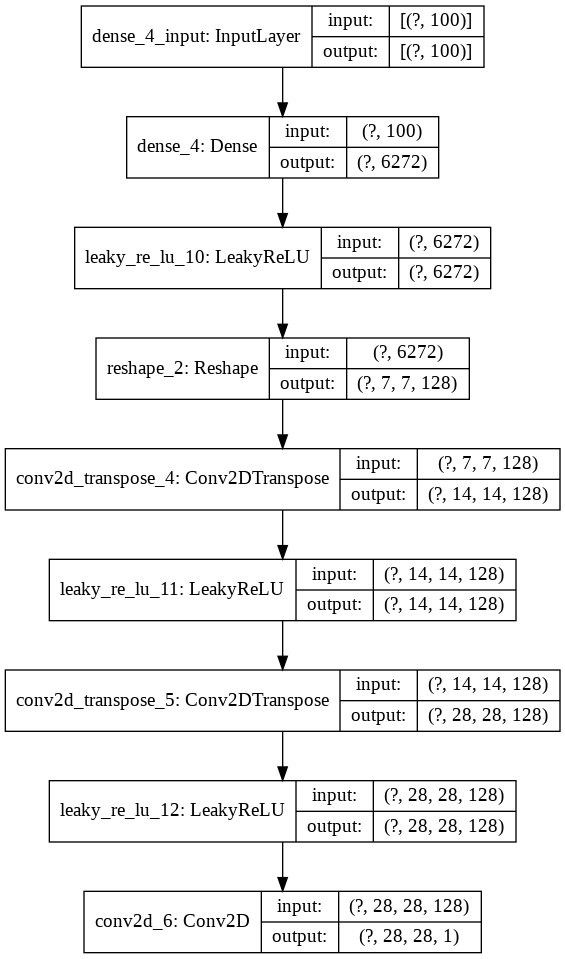

In [37]:
def generator(dim):
	model = Sequential(name="generator")
	## Updample Latent Space to 7 x 7 image dimensions 
	model.add(Dense(6272, input_dim=dim))
	model.add(LeakyReLU(alpha=0.2))
	## Reshape in Actual Channel form
	model.add(Reshape((7, 7, 128)))
	## shape = 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# shape = 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# length of the latent vector
dim = 100
# create the generator
G = generator(dim)
plot_model(G, show_shapes=True)

In [38]:
# generating 100 x 1 latent vectors using random normal distribution
def latent_vector(dim,n):
	return np.reshape(np.random.randn(n*dim),(n,dim)) 

examples = 30
input_examples = latent_vector(dim,examples)

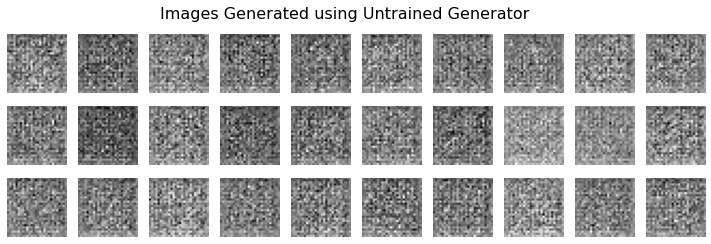

In [39]:
def custom_plotter(images, m=3, n=10, title='Example',subtitles=None,sz=(1.25,1.25)):
  if m*n!=len(images):
    print('Bad dimensions in custom_plotter')
    return
  plt.figure(figsize=(n*sz[0],m*sz[1]))
  for i in range(m * n):
    plt.subplot(m,n,i+1)
    plt.imshow(images[i, :, :, 0], cmap='gray_r')
    if subtitles:
      plt.title(subtitles[i])
    plt.axis('off')
  plt.suptitle(title,fontsize=16)
  plt.show()
  plt.close()
 
output_examples = G.predict(input_examples)
custom_plotter(output_examples,title='Images Generated using Untrained Generator')

###**Mixed Images for perceptual Comparision**

* Here we are plotting some actual images with dummy images (generated by untrained generator)
* Later on we will replace the dummy images with trained generator generated images, to see perceptually how it looks.
* There will be 20 fake images and 30 real images 

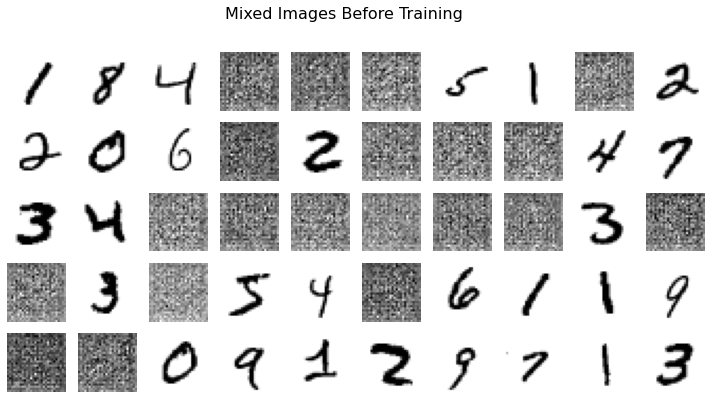

In [40]:
### Create fake samples from untrained generator
fake_samples = G.predict(input_examples[:20])

### Add the generated samples to original data
x_mix = np.concatenate((x[:30],fake_samples))

### Shuffle the data
np.random.shuffle(x_mix)

### Show 50 mixed samples
custom_plotter(x_mix,m=5,title='Mixed Images Before Training')

## Discriminator

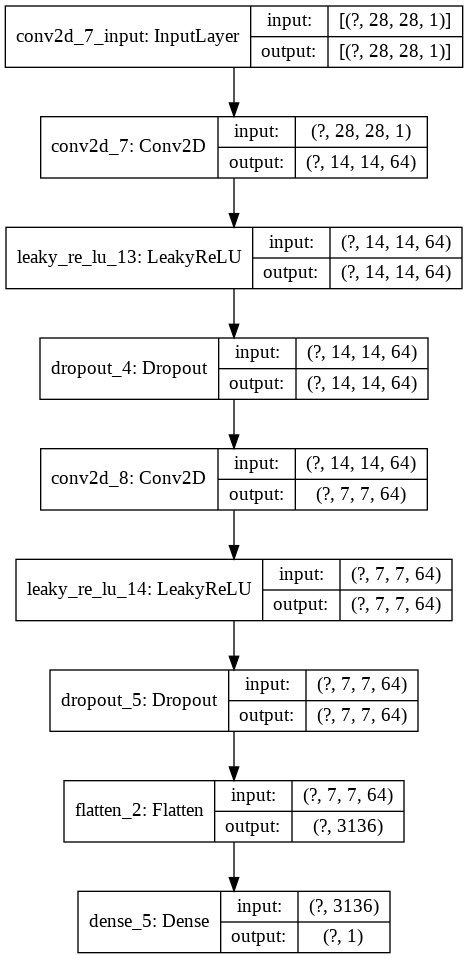

In [41]:
def discriminator(in_shape=(28,28,1)):
	model = Sequential(name="discriminator")
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
	los = 'binary_crossentropy'
	metric = 'accuracy'
	model.compile(opt,loss=los, metrics=[metric])
	return model

# create the discriminator
D = discriminator()
plot_model(D, show_shapes=True)

## GAN

### Design GAN

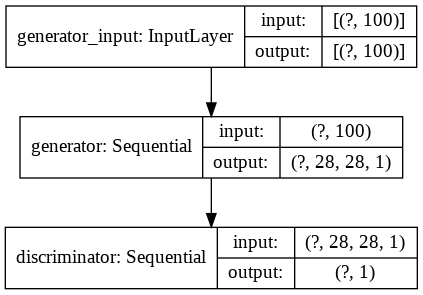

In [43]:
def gan(g, d):
	
	# gan only trains generator using values from discriminator
	# note. discriminator will still be able to train outside gan
	d.trainable = False

	model = Sequential(name='GAN')
	model.add(g)
	model.add(d)
	opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(opt,'binary_crossentropy')
	return model

# create the gan
GAN = gan(G, D)
plot_model(GAN, show_shapes=True)

### Train GAN

In [44]:
hist = { 'D':{} , 'G':{}}
hist['D'] = {'real':{}, 'fake':{} , 'loss':[], 'accuracy':[]}
hist['D']['real'] = {'loss':[], 'accuracy':[]}
hist['D']['fake'] = {'loss':[], 'accuracy':[]}
hist['G'] = {'loss':[], 'accuracy':[]}

# choose n real images set labels = 1
def real_images(x, n):
	return x[np.random.randint(0, x.shape[0], n)], np.ones((n, 1))

# generate n fake images and set labels = 0
def fake_images(g, dim, n):
	return g.predict(latent_vector(dim, n)), np.zeros((n, 1))
 
# generating latent vectors for gan input
def generate_gan_samples(dim, n):
	return latent_vector(dim, n), np.ones((n, 1))

# train the generator and discriminator
def train(g, d, gan, x, dim= 100, epochs= 25, batch= 256):
  iterations = int(x.shape[0] / batch)
  n = int(batch / 2)
  st = time()
  for i in range(epochs):
    stt = time()
    for j in range(iterations):
      X_real, y_real = real_images(x, n)
      X_fake, y_fake = fake_images(g, dim, n)
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
      d_loss, d_acc = d.train_on_batch(X, y)
      X_gan, y_gan = generate_gan_samples(dim, batch)
      g_loss = gan.train_on_batch(X_gan, y_gan)
    hist['D']['loss'].append(d_loss)
    hist['G']['loss'].append(g_loss)
    enn=time()
    t=enn-stt
    if i%5==4 or i==0:
      print('Epoch= {}, d_loss= {}, g_loss= {}, t= {}s'.format(i+1, d_loss, g_loss,t))
  en=time()
  t = en-st
  min, sec = t//60, t%60
  print("Training Finished In: {} Minutes {} Seconds".format(min,sec))


# train model
train(G, D, GAN, x)  

Epoch= 1, d_loss= 0.8182816505432129, g_loss= 0.8511245250701904, t= 47.778093099594116s
Epoch= 5, d_loss= 0.6753485202789307, g_loss= 0.7418947815895081, t= 46.24830627441406s
Epoch= 10, d_loss= 0.6736888289451599, g_loss= 0.6916974186897278, t= 46.397260665893555s
Epoch= 15, d_loss= 0.6904157996177673, g_loss= 0.7028338313102722, t= 46.29910206794739s
Epoch= 20, d_loss= 0.6951546669006348, g_loss= 0.742020845413208, t= 46.6184606552124s
Epoch= 25, d_loss= 0.681973397731781, g_loss= 0.6753641963005066, t= 46.04605269432068s
Training Finished In: 19.0 Minutes 20.99399447441101 Seconds


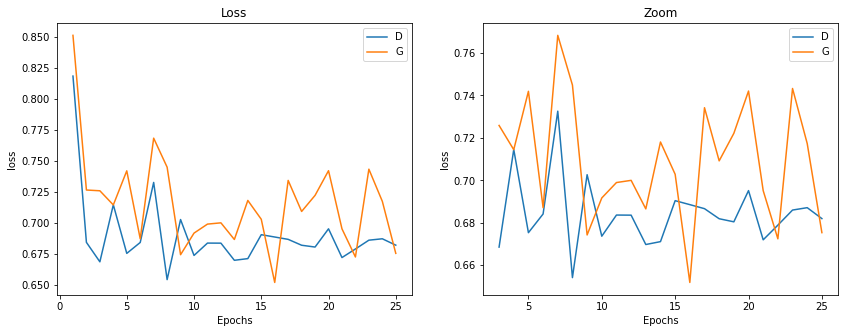

In [45]:
### Validation vs Training accuaracy for Every model ###
plt.figure(figsize=(14,5))
plt.subplot(121)
metric = 'loss'
myplot(hist['D'], metric,label='D')
myplot(hist['G'], metric,label='G')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(122)
metric = 'loss'
myplot(hist['D'], metric,st=2,label='D')
myplot(hist['G'], metric,st=2,label='G')
plt.legend(loc='best')
plt.title('Zoom')
plt.show()

**Observation**
*  We can see that that both discriminator and generator slowly converge to the same value as the number of epochs increases
*  During the training both the losses of generator and the discriminator are always on the opposite side, meaning
* When generator learns better it beats the discriminator hence discriminator loss goes up, and vice versa
* But after both are trained prpoperly loss values converge towards a comman point and no further training is possible
* Hence we can only aim for minimizing the loss for overall GAN and not just the generator or just the discriminator.

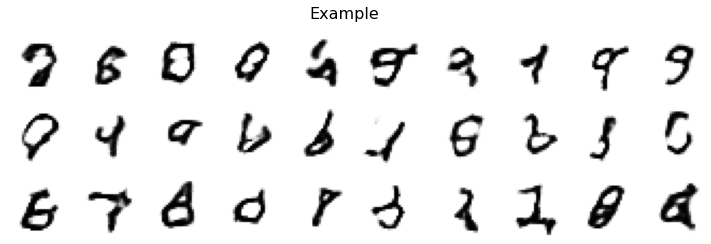

In [55]:
### Plot the examples
input_examples = latent_vector(dim,examples)
output_examples = G.predict(input_examples)
custom_plotter(output_examples)

### Plotting the mix of actual images with generated images

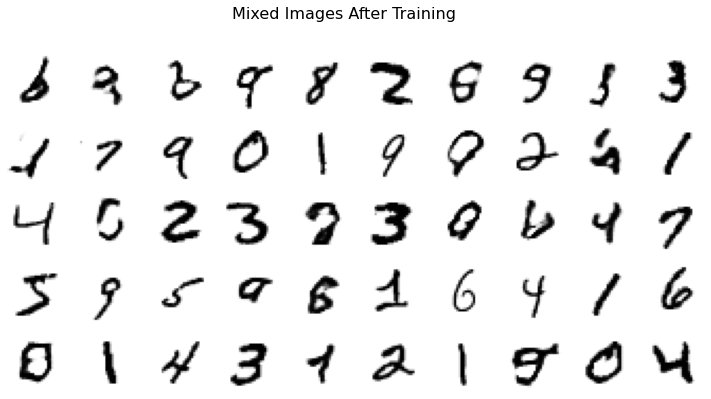

In [56]:
### Create fake samples from untrained generator
fake_samples = G.predict(input_examples[:20])

### Add the generated samples to original data
x_mix = np.concatenate((x[:30],fake_samples))

### Shuffle the data
np.random.shuffle(x_mix)

### Show 50 mixed samples
custom_plotter(x_mix,m=5,title='Mixed Images After Training')

# Task 2

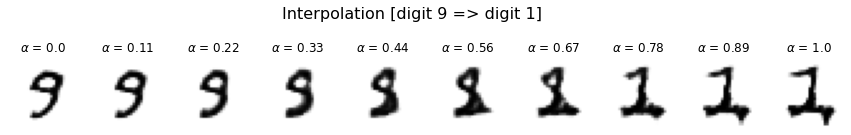

In [60]:
c1 = input_examples[27].copy()
c2 = input_examples[9].copy()

alpha = np.reshape(np.linspace(0,1,10),(10,1))
latent_interpolated = alpha*c1 + (1-alpha)*c2

### Plot the samples
interpolated_examples = G.predict(latent_interpolated)
custom_plotter(interpolated_examples, m=1,title='Interpolation [digit 9 => digit 1]', subtitles= [ r'$\alpha$ = ' + str(round(i[0],2))  for i in alpha], sz=(1.5,2.5))

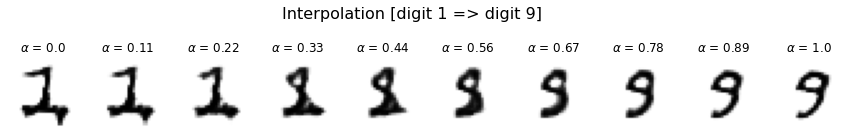

In [61]:
c1 = input_examples[9].copy()
c2 = input_examples[27].copy()

alpha = np.reshape(np.linspace(0,1,10),(10,1))
latent_interpolated = alpha*c1 + (1-alpha)*c2

### Plot the samples
interpolated_examples = G.predict(latent_interpolated)
custom_plotter(interpolated_examples, m=1,title='Interpolation [digit 1 => digit 9]', subtitles= [ r'$\alpha$ = ' + str(round(i[0],2))  for i in alpha], sz=(1.5,2.5))

* We can clearly see that as the interpolation coefficeint increases the image translates from One Digit Class (c1) to Another Digit Class (c2)
* For alpha = 0, we get only effect of one class (c1)
* For alpha = 1, we get only effect of one class (c2)
* This concept has lots of applications in **Image to Image translation between to different domains**.

# Task 3

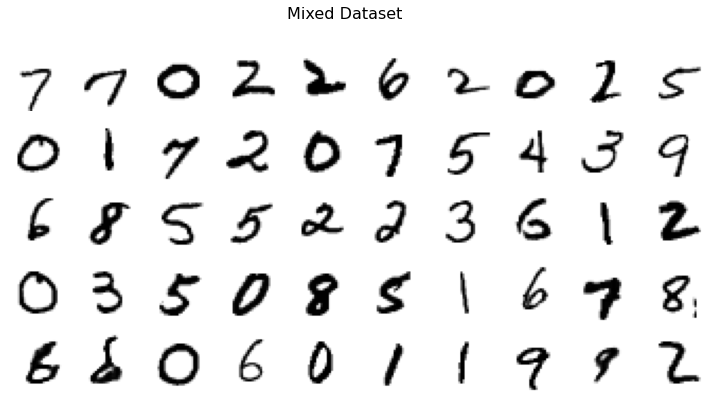

In [62]:
### Size of the new generated dataset
fake_sample_size= 10000

### Create fake samples from trained generator
latent_fake_samples= latent_vector(dim,fake_sample_size)
fake_samples = G.predict(latent_fake_samples)

### Add the generated samples to original data
x_new = np.concatenate((x,fake_samples))

### Shuffle the data
np.random.shuffle(x_new)

### Resize the new dataset such size of old dataset is same as new dataset (so that comparision is unbiased)
x_new = x_new[:59904]

### Show 50 mixed samples
custom_plotter(x_new[:50],m=5,title='Mixed Dataset')

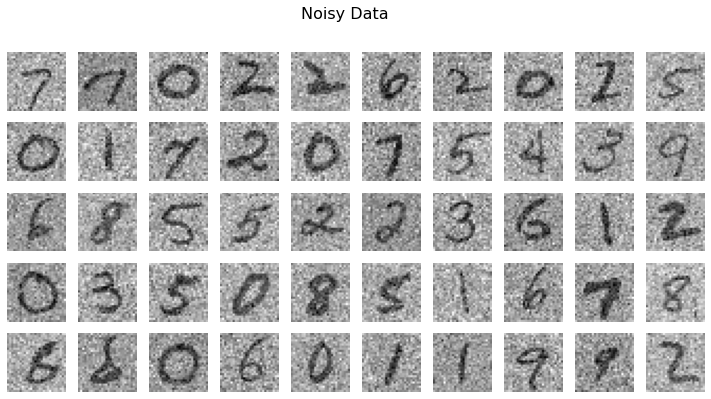

In [63]:
### Add the noise to the dataset
x_new_noisy = x_new + np.random.normal(0,0.3,x_new.shape)
x_noisy = x + np.random.normal(0,0.3,x.shape)
xt_noisy = xt + np.random.normal(0,0.3,xt.shape)

custom_plotter(x_new_noisy[:50],m=5,title='Noisy Data')

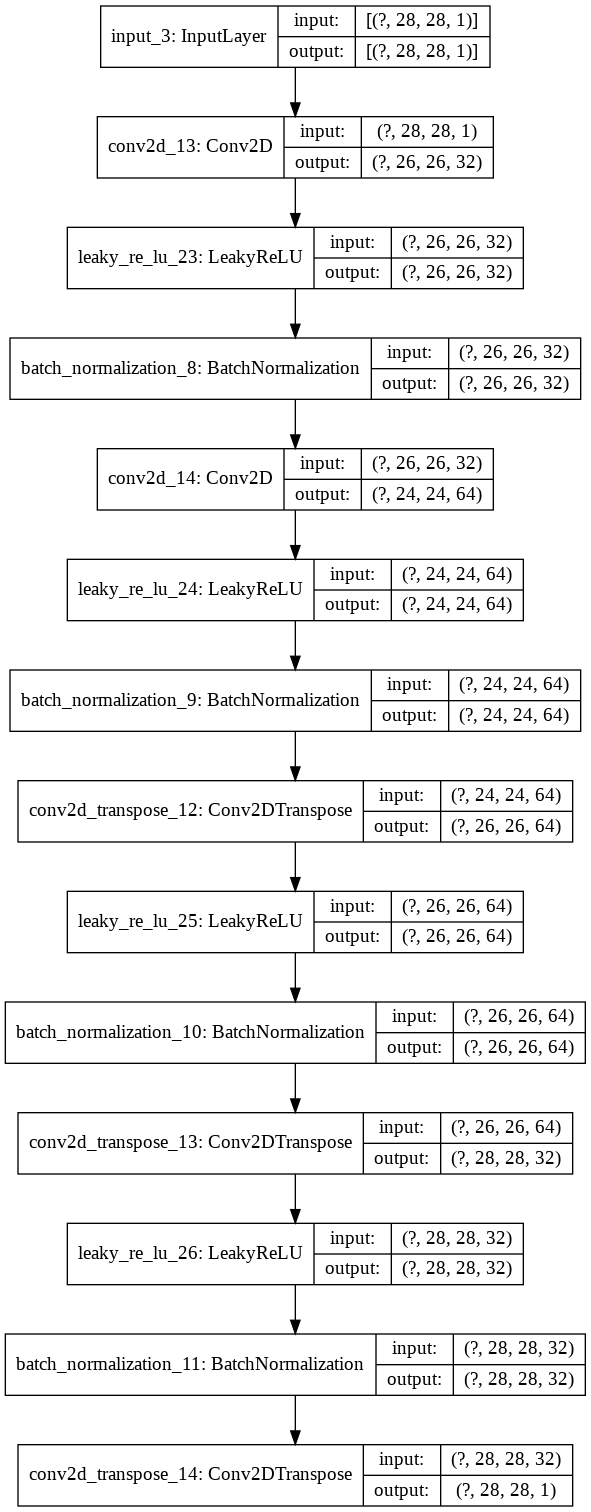

In [67]:
## Denoising Neural Network
def build():
  model = Sequential()
  model.add(Input((28,28,1)))
  model.add(Conv2D(32, 3))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Conv2D(64, 3))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Conv2DTranspose(64, 3))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Conv2DTranspose(32, 3))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Conv2DTranspose(1,3,padding="same"))
  model.compile('adam', 'mse', 'mse')
  return model

denoiser1 = build()
denoiser2 = build()
plot_model(denoiser1, show_shapes= True, show_layer_names= True)

In [70]:
### Train function for neural network
def train(model,x, y, xt, yt):
  return model.fit(x, y, epochs=25, batch_size=256, validation_data=(xt,yt), verbose=0).history

In [71]:
hist1 = train(denoiser1,x_new_noisy,x_new,xt_noisy,xt)
hist2 = train(denoiser2,x_noisy,x,xt_noisy,xt)

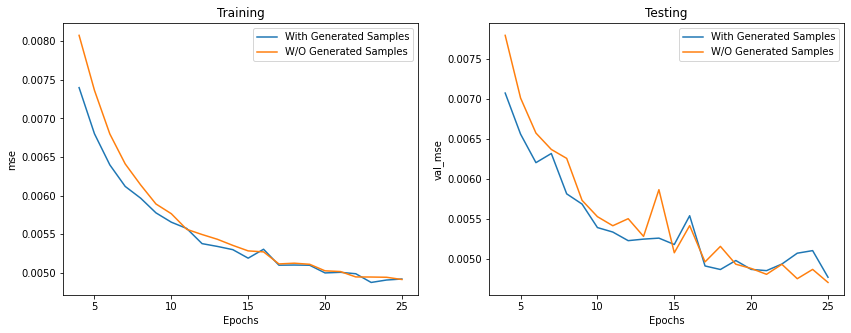

In [73]:
s = 3
plt.figure(figsize=(14,5))
plt.subplot(121)
myplot(hist1,'mse',st=s,label='With Generated Samples')
myplot(hist2,'mse',st=s,label='W/O Generated Samples')
plt.legend(loc='best')
plt.title('Training')

plt.subplot(122)
myplot(hist1,'val_mse',st=s,label='With Generated Samples')
myplot(hist2,'val_mse',st=s,label='W/O Generated Samples')
plt.legend(loc='best')
plt.title('Testing')
plt.show()

* We observe that difference for training and testing error is almost similar for both the cases, this could be because the **relative features** of images that need to be learned by CNN are both preserved in computer generated images.
* Hence we can use this knowledge for **data augmentation to create synthetic data**

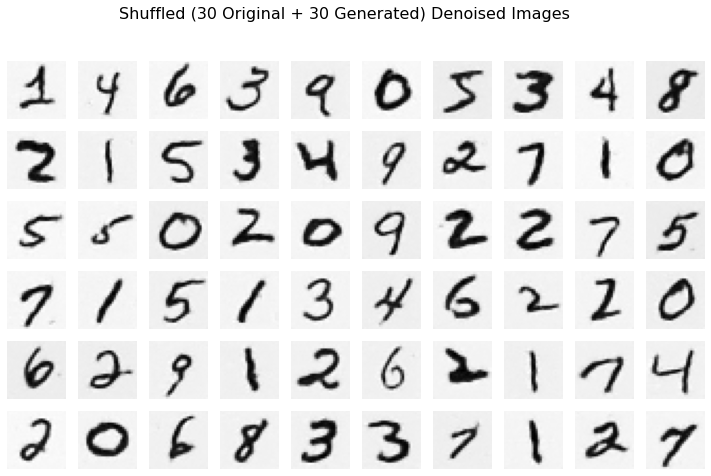

In [74]:
y1 = denoiser1.predict(x_new_noisy[:30])
y2 = denoiser2.predict(x_noisy[:30])

y = np.concatenate((y1,y2))

### Shuffle the data
np.random.shuffle(y)

custom_plotter(y,m=6,title='Shuffled (30 Original + 30 Generated) Denoised Images')

* Visually also we observe that the denoising part is done very well by both type of training datasets (The Original and The Mixed Generated).